In [17]:
import numpy as np
import spreadingcode as sc
import matplotlib.pyplot as plt

# get no-delay spreading code 
c_LR = sc.PRN(1)

# make a function to sample this 

def sample_sequence(prn_sequence, sampling_rate):
    # Determine the number of samples per chip
    samples_per_chip = int(sampling_rate / len(prn_sequence))

    # Repeat each element of the PRN sequence 'samples_per_chip' times
    sampled_sequence = np.repeat(prn_sequence, samples_per_chip)

    return sampled_sequence

# Assuming you already have the PRN sequence generated and stored in 'prn_sequence'
prn_sequence = sc.PRN(1)

# Sample the PRN sequence at 2 times the PRN chip rate
samples_per_chip = 100
sampling_rate = samples_per_chip * 1.023e3 # this is samples/chip * chips in 1 code period 
sampled_sequence = sample_sequence(prn_sequence, sampling_rate)

# The 'sampled_sequence' now contains the PRN sequence sampled at the desired rate

def calculate_acf(sequence):
    # when using np.correlate with the same sequence, the ACF is produced
    acf = np.correlate(sequence, sequence, mode='full')
    return acf

sampled_ACF = calculate_acf(sampled_sequence)

def plot_acf(acf, sampling_rate, samples_around_peak=100):
    # Find the index of the peak (maximum) value in the ACF
    peak_index = np.argmax(acf)

    # Calculate the delay range to plot around the peak
    start_delay = max(0, peak_index - samples_around_peak // 2)
    end_delay = min(len(acf), peak_index + samples_around_peak // 2)

    # Create a range of delays for the plot
    delays = np.arange(start_delay, end_delay)

    # Convert the delay values to represent chips instead of samples
    delays_in_chips = np.arange(start_delay, end_delay) / samples_per_chip - 1023

    print("%i Samples Plotted," % len(delays_in_chips))

    plt.stem(delays_in_chips, acf[delays], use_line_collection=True)
    plt.xlabel('Delay (chips)')
    plt.ylabel('ACF Value')
    plt.title('Autocorrelation Function (ACF) with Sampling Rate: {} ms'.format(sampling_rate))
    plt.grid(True)
    plt.show()



300 Samples Plotted,


C:\Users\logan\AppData\Local\Temp\ipykernel_33784\3190497572.py:52: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(delays_in_chips, acf[delays], use_line_collection=True)


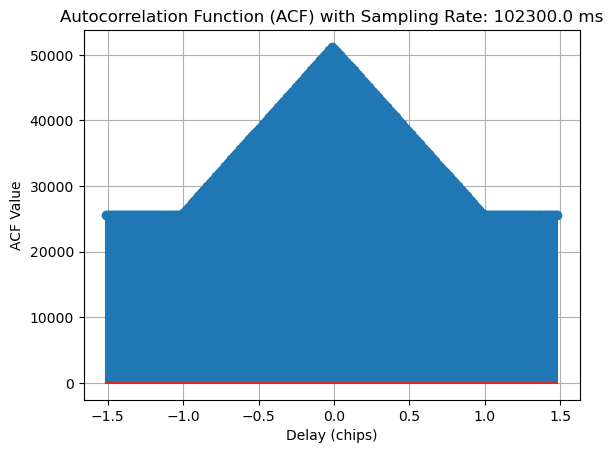

In [18]:
# Assuming you have already computed 'sampled_ACF'
# and you want to save it to a file called 'sampled_ACF.npy'
np.save('sampled_ACF.npy', sampled_ACF)

# To load the saved array back into your script
loaded_sampled_ACF = np.load('sampled_ACF.npy')

plot_acf(sampled_ACF, sampling_rate, 300)

3


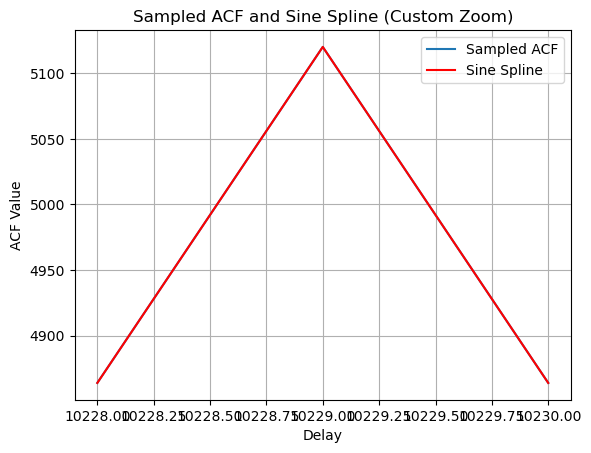

In [9]:
from scipy.interpolate import UnivariateSpline

# apply a sine spline to the sampled region around the ACF peak to show sampling effect

# We'll examine the second derivative of the ACF sequence to detect a change in curvature around the ACF, and apply 
# the spline there

# Calculate the second derivative (curvature) of the ACF
acf_slope = np.diff(sampled_ACF)
acf_curvature = np.diff(acf_slope)

# Find the index where the curvature starts to change significantly
max_curvature_index = np.argmax(np.abs(acf_curvature))

# Define the threshold for significant curvature
curvature_threshold = 0.5 * np.abs(acf_curvature[max_curvature_index])

# Find the points where the curvature exceeds the threshold
significant_curvature_indices = np.where(np.abs(acf_curvature) > curvature_threshold)[0]

# Define the region around the peak based on the significant curvature
N = 100
region_start = max(0, significant_curvature_indices[0] - N)
region_end = min(len(sampled_ACF), significant_curvature_indices[-1] + N + 1)
region_indices = np.arange(region_start, region_end)

region_acf = sampled_ACF[region_indices]
spline = UnivariateSpline(region_indices, region_acf, k=3, s=0)

def plot_acf_with_custom_zoom(sampled_ACF, spline, peak_index, num_points_around_peak):
    # Calculate the starting and ending indices for the zoomed region around the peak
    start_delay = max(0, peak_index - num_points_around_peak)
    end_delay = min(len(sampled_ACF), peak_index + num_points_around_peak + 1)
    
    # Create a range of delays for the plot
    delays = np.arange(start_delay, end_delay)
    print(len(delays))

    plt.plot(delays, sampled_ACF[delays], label='Sampled ACF')
    plt.plot(delays, spline(delays), 'r', label='Sine Spline')
    plt.xlabel('Delay')
    plt.ylabel('ACF Value')
    plt.title('Sampled ACF and Sine Spline (Custom Zoom)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have 'sampled_ACF', 'spline', 'peak_index' from previous steps
peak_index = np.argmax(np.abs(sampled_ACF))
num_points_around_peak = 1  # Adjust the number of points as desired
plot_acf_with_custom_zoom(sampled_ACF, spline, peak_index, num_points_around_peak)


